This notebook contains cells to train GAN (Cramer GAN modification) to learn data distribution. Unlike in standard training pipelines, the train/test sets are two disjoint sets.

**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 3.6 MB/s 


In [8]:
import datetime
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import \
    efficiency_momentum_with_uncertainty
from experiments.efficiency.utils import (efficiency_momentum,
                                          ensemble_and_ref_model_inference,
                                          tf_to_numpy_dataset,
                                          threshold_selection)
from src.dataset import CramerGANDataset
from src.cramer_gan_trainer import CramerGANTrainer
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)

from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropV2Subcl, RICHGeneratorMCDropV3

from experiments.ring_test.utils import split_by_density_rings

### Data preparation

The RICH dataset contains sets of data for different types of particles. Each datapoint in RICH consists of $\mathbb{X}, \mathbb{Y}$ and weight $w$, where the input data $\mathbb{X} \in \mathbb{R}^3$, where features of input data consist of pseudorapidity (ETA), momentum (P), number of tracks; the output is data $\mathbb{Y} \in \mathbb{R}^5$, where each feature is the difference of log-likelihood values between particle hypothesis and pion hypothesis. The particles are kaon, proton, muon, electron, and values below the threshold.

In [6]:
particle_type = 'pion'

data_dir = 'rich'

In [7]:
ls rich

kaon2_-_down_2016_.csv  muon_-_down_2016_.csv   pion_-_down_2016_.csv
kaon2_+_down_2016_.csv  muon_+_down_2016_.csv   pion_+_down_2016_.csv
kaon2_-_up_2016_.csv    muon_-_up_2016_.csv     pion_-_up_2016_.csv
kaon2_+_up_2016_.csv    muon_+_up_2016_.csv     pion_+_up_2016_.csv
kaon_-_down_2016_.csv   pion2_-_down_2016_.csv  proton_-_down_2016_.csv
kaon_+_down_2016_.csv   pion2_+_down_2016_.csv  proton_+_down_2016_.csv
kaon_-_up_2016_.csv     pion2_-_up_2016_.csv    proton_-_up_2016_.csv
kaon_+_up_2016_.csv     pion2_+_up_2016_.csv    proton_+_up_2016_.csv


In this notebook we make train/test split as two disjoint sets. Taking the symmetry of the data after standardization, we split the data by the line $y = x$ (we consider pseudorapidity (ETA) and momentum (P) for split).

In [15]:
def split_into_rings(df_train, df_test):
    train = split_by_density_rings(df_train, int(1e6))[0][0]
    test = split_by_density_rings(df_test, int(5e5))[0][1]

    return train, test

In [16]:
data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle_type,
                                                        dtype=np.float32, log=True, 
                                                        sample_fn=split_into_rings)

Reading and concatenating datasets:
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.0639586448669434
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


100%|██████████| 2/2 [02:51<00:00, 85.92s/it]


Len data rings: 2


100%|██████████| 2/2 [01:23<00:00, 41.80s/it]

Len data rings: 2


In [17]:
data_train.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
366  -0.307867 -1.824419  -0.365664  ...   -0.221853       -1.019168      -0.823861
631  -0.243993 -1.620101  -0.246271  ...   -0.242429       -1.425089       0.976397
3420 -0.736224 -1.285834  -0.777040  ...   -0.251525       -1.207805       1.065390
4004  0.119559 -1.412164   0.067722  ...   -0.227071       -1.332604       1.177810
4252 -0.510254 -1.906169  -0.627080  ...   -0.214674       -0.490308       1.073720

[5 rows x 9 columns]

In [18]:
data_val.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
5589   0.161278 -1.401098  -0.177290  ...   -0.586833       -0.856134       0.547299
7076   0.241216 -0.558405   0.027078  ...   -0.574307       -1.500784       1.164400
10062  0.765348  2.183743   0.396583  ...   -0.555744        0.856369       1.225840
13905  0.037584 -1.341326  -0.147037  ...   -0.582952       -2.685595       1.215190
18284  0.494396 -0.556579   0.048137  ...   -0.554370       -0.684951      -3.154320

[5 rows x 9 columns]

In [19]:
data_train.shape, data_val.shape

((1000302, 9), (499926, 9))

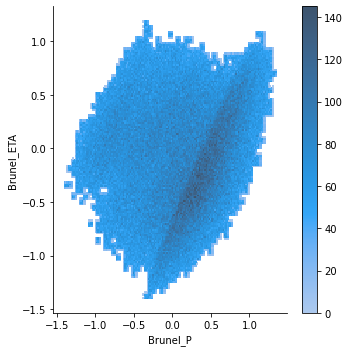

In [20]:
sns.displot(data_train, x='Brunel_P', y='Brunel_ETA', cbar=True)

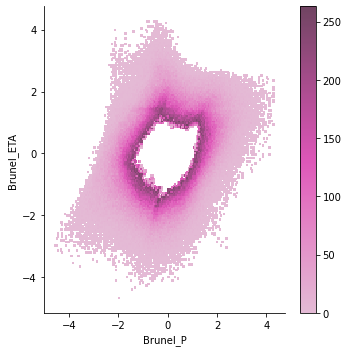

In [21]:
sns.displot(data_val, x='Brunel_P', y='Brunel_ETA', cbar=True, color='tab:pink')

In [22]:
data_train.shape

(1000302, 9)

In [23]:
data_val.shape

(499926, 9)

### Model definition

The generator is six-layer mlp with dropout after each layer except last. Each hidden layer contains 128 units. The dropout rate is usually in the range of 0.1 - 0.2 (calibration results). This rate is enough to train a "diverse" ensemble keeping the performance on benchmark at a considerable level. The discriminator is six-layer mlp. 


In [ ]:
# generator = RichMCDropV2Subcl(drop_rate=0.2)
# generator.build((None, 3))

generator = RICHGeneratorMCDropV3()
generator.summary()

In [32]:
generator.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=23883.428>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43266.953>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43236.22>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43383.508>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43260.934>]

In [33]:
discriminator = RICHDiscriminator()
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 8)            0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 256)          100224      concatenate_1[0][0]        

We use Cramer GAN modification to train generator learn the distribution. [Link](https://arxiv.org/abs/1705.10743) to Cramer GAN for more details. The training configuration:
 - Batch size: 1000
 - Critic steps: 15
 - Generator optimizer: RMSProp with learning rate 0.0002
 - Discriminator optimizer: RMSProp with learning rate 0.0002
 - Use weights: True
 - Number of epochs: 400

In [34]:
critic_batch_size = 15
batch_size = int(1e3)

num_val = data_val.shape[0]
num_train = data_train.shape[0]

train_dataset_config = {
    'data_np': data_train,
    'iter_batch_size': critic_batch_size + 1,
    'batch_size': batch_size
}

val_dataset_config = {
    'data_np': data_val,
    'num_instances': 1,
    'iter_batch_size': 1,
    'batch_size': num_val,
    'shuffle': False
}

dataset_train = CramerGANDataset(**train_dataset_config)
dataset_val = CramerGANDataset(**val_dataset_config)

print("Train dataset shape: ", tf.data.experimental.cardinality(dataset_train.dataset))
print("Val dataset shape: ", tf.data.experimental.cardinality(dataset_val.dataset))

Train dataset shape:  tf.Tensor(62, shape=(), dtype=int64)
Val dataset shape:  tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
checkpoint_base = 'checkpoints'
exp_name = 'variational_dropout_ring_test_cramer_weighted_reg_value_5e-7'
checkpoint_dir = os.path.join(checkpoint_base, exp_name)

logs_base = 'logs'
log_dir = os.path.join(logs_base, exp_name)

generator_optimizer = tf.keras.optimizers.RMSprop(2e-4) 
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4)

trainer_config = {
    'generator': generator,
    'discriminator': discriminator,
    'generator_optimizer': generator_optimizer,
    'discriminator_optimizer': discriminator_optimizer,
    'checkpoint_dir': checkpoint_dir,
    'log_dir': log_dir,
    'reg_loss_lambda': 5e-7
}

trainer = CramerGANTrainer(**trainer_config)

In [37]:
trainer.fit_cramer(400, dataset_train, dataset_val, weighted=True)

100%|██████████| 992000/992000 [03:23<00:00, 4867.46it/s, gen_loss=0.367, disc_loss=-.213, reg_loss=1.95e+5]


Time taken for epoch 1 is 203.8051369190216 sec



100%|██████████| 992000/992000 [00:46<00:00, 21340.26it/s, gen_loss=0.424, disc_loss=-.429, reg_loss=1.93e+5]


Time taken for epoch 2 is 46.489001989364624 sec



100%|██████████| 992000/992000 [00:46<00:00, 21423.39it/s, gen_loss=0.355, disc_loss=-.268, reg_loss=1.91e+5]


Time taken for epoch 3 is 46.308982849121094 sec



100%|██████████| 992000/992000 [00:45<00:00, 21639.52it/s, gen_loss=0.201, disc_loss=-.25, reg_loss=1.9e+5]


Time taken for epoch 4 is 45.8470618724823 sec



100%|██████████| 992000/992000 [00:46<00:00, 21496.62it/s, gen_loss=0.177, disc_loss=-.366, reg_loss=1.89e+5]


Time taken for epoch 5 is 46.150914907455444 sec



100%|██████████| 992000/992000 [00:46<00:00, 21506.60it/s, gen_loss=0.363, disc_loss=-.208, reg_loss=1.87e+5]


Time taken for epoch 6 is 46.12912702560425 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.54it/s, gen_loss=0.0632, disc_loss=-.0692, reg_loss=1.86e+5]


Time taken for epoch 7 is 81.97775936126709 sec



100%|██████████| 992000/992000 [00:45<00:00, 21592.71it/s, gen_loss=0.0328, disc_loss=-.115, reg_loss=1.85e+5]


Time taken for epoch 8 is 45.94708228111267 sec



100%|██████████| 992000/992000 [00:45<00:00, 21594.55it/s, gen_loss=0.203, disc_loss=-.307, reg_loss=1.85e+5]


Time taken for epoch 9 is 45.94182729721069 sec



100%|██████████| 992000/992000 [00:45<00:00, 21634.85it/s, gen_loss=0.324, disc_loss=-.217, reg_loss=1.84e+5]


Time taken for epoch 10 is 45.8556866645813 sec



100%|██████████| 992000/992000 [00:45<00:00, 21655.58it/s, gen_loss=0.41, disc_loss=-.0286, reg_loss=1.83e+5]


Time taken for epoch 11 is 45.812265157699585 sec



100%|██████████| 992000/992000 [00:46<00:00, 21559.75it/s, gen_loss=-.101, disc_loss=-.101, reg_loss=1.82e+5]


Time taken for epoch 12 is 46.01645088195801 sec



100%|██████████| 992000/992000 [00:45<00:00, 21715.24it/s, gen_loss=0.167, disc_loss=-.295, reg_loss=1.82e+5]


Time taken for epoch 13 is 45.68623113632202 sec



100%|██████████| 992000/992000 [00:45<00:00, 21758.79it/s, gen_loss=-.137, disc_loss=-.0712, reg_loss=1.81e+5]


Time taken for epoch 14 is 45.594826459884644 sec



100%|██████████| 992000/992000 [00:45<00:00, 21757.08it/s, gen_loss=0.0943, disc_loss=-.323, reg_loss=1.8e+5]


Time taken for epoch 15 is 45.598161458969116 sec



100%|██████████| 992000/992000 [00:45<00:00, 21752.11it/s, gen_loss=-.15, disc_loss=-.121, reg_loss=1.79e+5]


Time taken for epoch 16 is 45.608898639678955 sec



100%|██████████| 992000/992000 [00:45<00:00, 21734.89it/s, gen_loss=0.252, disc_loss=0.0231, reg_loss=1.79e+5]


Time taken for epoch 17 is 45.647135496139526 sec



100%|██████████| 992000/992000 [00:45<00:00, 21796.12it/s, gen_loss=0.106, disc_loss=-.191, reg_loss=1.78e+5]


Time taken for epoch 18 is 45.51639246940613 sec



100%|██████████| 992000/992000 [00:45<00:00, 21608.36it/s, gen_loss=0.0808, disc_loss=-.196, reg_loss=1.77e+5]


Time taken for epoch 19 is 45.91234302520752 sec



100%|██████████| 992000/992000 [00:45<00:00, 21680.95it/s, gen_loss=0.132, disc_loss=-.0653, reg_loss=1.76e+5]


Time taken for epoch 20 is 45.8369026184082 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.44it/s, gen_loss=-.0445, disc_loss=-.0856, reg_loss=1.76e+5]


Time taken for epoch 21 is 81.98429417610168 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.61it/s, gen_loss=0.0705, disc_loss=-.419, reg_loss=1.75e+5]


Time taken for epoch 22 is 81.9832980632782 sec



100%|██████████| 992000/992000 [00:46<00:00, 21524.84it/s, gen_loss=-.0855, disc_loss=0.0853, reg_loss=1.74e+5]


Time taken for epoch 23 is 46.08999967575073 sec



100%|██████████| 992000/992000 [00:46<00:00, 21556.81it/s, gen_loss=-.0959, disc_loss=-.0541, reg_loss=1.74e+5]


Time taken for epoch 24 is 46.021780014038086 sec



100%|██████████| 992000/992000 [00:46<00:00, 21554.11it/s, gen_loss=-.0419, disc_loss=-.275, reg_loss=1.73e+5]


Time taken for epoch 25 is 46.028348445892334 sec



100%|██████████| 992000/992000 [00:46<00:00, 21519.11it/s, gen_loss=0.128, disc_loss=0.00629, reg_loss=1.72e+5]


Time taken for epoch 26 is 46.10246753692627 sec



100%|██████████| 992000/992000 [00:45<00:00, 21573.75it/s, gen_loss=0.197, disc_loss=-.318, reg_loss=1.71e+5]


Time taken for epoch 27 is 45.98664999008179 sec



100%|██████████| 992000/992000 [00:45<00:00, 21599.85it/s, gen_loss=0.253, disc_loss=0.0749, reg_loss=1.71e+5]


Time taken for epoch 28 is 45.930973052978516 sec



100%|██████████| 992000/992000 [00:45<00:00, 21642.12it/s, gen_loss=0.237, disc_loss=-.45, reg_loss=1.7e+5]


Time taken for epoch 29 is 45.841277837753296 sec



100%|██████████| 992000/992000 [00:45<00:00, 21570.35it/s, gen_loss=0.341, disc_loss=-.113, reg_loss=1.69e+5]


Time taken for epoch 30 is 45.99279737472534 sec



100%|██████████| 992000/992000 [00:46<00:00, 21474.95it/s, gen_loss=0.448, disc_loss=-.0242, reg_loss=1.69e+5]


Time taken for epoch 31 is 46.197248220443726 sec



100%|██████████| 992000/992000 [00:46<00:00, 21534.64it/s, gen_loss=0.0663, disc_loss=-.177, reg_loss=1.68e+5]


Time taken for epoch 32 is 46.06951665878296 sec



100%|██████████| 992000/992000 [00:46<00:00, 21410.41it/s, gen_loss=-.0702, disc_loss=-.141, reg_loss=1.67e+5]


Time taken for epoch 33 is 46.336336851119995 sec



100%|██████████| 992000/992000 [00:46<00:00, 21273.99it/s, gen_loss=0.0564, disc_loss=-.0887, reg_loss=1.67e+5]


Time taken for epoch 34 is 46.6365864276886 sec



100%|██████████| 992000/992000 [00:47<00:00, 21105.52it/s, gen_loss=0.12, disc_loss=-.0185, reg_loss=1.66e+5]


Time taken for epoch 35 is 47.00686979293823 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.36it/s, gen_loss=0.129, disc_loss=-.153, reg_loss=1.66e+5]


Time taken for epoch 36 is 81.97849607467651 sec



100%|██████████| 992000/992000 [00:46<00:00, 21347.86it/s, gen_loss=-.0299, disc_loss=-.171, reg_loss=1.65e+5]


Time taken for epoch 37 is 46.47232794761658 sec



100%|██████████| 992000/992000 [00:46<00:00, 21503.56it/s, gen_loss=0.221, disc_loss=-.0453, reg_loss=1.64e+5]


Time taken for epoch 38 is 46.13675093650818 sec



100%|██████████| 992000/992000 [00:46<00:00, 21433.07it/s, gen_loss=-.0899, disc_loss=0.0798, reg_loss=1.64e+5]


Time taken for epoch 39 is 46.2889449596405 sec



100%|██████████| 992000/992000 [00:46<00:00, 21463.40it/s, gen_loss=0.204, disc_loss=-.0946, reg_loss=1.63e+5]


Time taken for epoch 40 is 46.28883099555969 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.42it/s, gen_loss=0.31, disc_loss=-.0363, reg_loss=1.63e+5]


Time taken for epoch 41 is 81.97751259803772 sec



100%|██████████| 992000/992000 [00:46<00:00, 21263.22it/s, gen_loss=0.0597, disc_loss=-.0102, reg_loss=1.62e+5]


Time taken for epoch 42 is 46.65932536125183 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.26it/s, gen_loss=-.0266, disc_loss=-.199, reg_loss=1.61e+5]


Time taken for epoch 43 is 81.98692512512207 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.47it/s, gen_loss=0.0415, disc_loss=-.0839, reg_loss=1.61e+5]


Time taken for epoch 44 is 81.98714709281921 sec



100%|██████████| 992000/992000 [00:46<00:00, 21439.89it/s, gen_loss=-.185, disc_loss=-.0713, reg_loss=1.6e+5]


Time taken for epoch 45 is 46.27508068084717 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.31it/s, gen_loss=0.0983, disc_loss=-.229, reg_loss=1.6e+5]


Time taken for epoch 46 is 81.97908353805542 sec



100%|██████████| 992000/992000 [00:46<00:00, 21363.82it/s, gen_loss=0.0581, disc_loss=-.0401, reg_loss=1.59e+5]


Time taken for epoch 47 is 46.43755793571472 sec



100%|██████████| 992000/992000 [00:45<00:00, 21571.70it/s, gen_loss=-.135, disc_loss=-.127, reg_loss=1.59e+5]


Time taken for epoch 48 is 45.990514278411865 sec



100%|██████████| 992000/992000 [00:45<00:00, 21566.00it/s, gen_loss=0.0863, disc_loss=-.0295, reg_loss=1.58e+5]


Time taken for epoch 49 is 46.004035234451294 sec



100%|██████████| 992000/992000 [00:45<00:00, 21579.13it/s, gen_loss=0.245, disc_loss=0.0767, reg_loss=1.58e+5]


Time taken for epoch 50 is 45.974897384643555 sec



100%|██████████| 992000/992000 [00:45<00:00, 21619.92it/s, gen_loss=-.0846, disc_loss=-.172, reg_loss=1.57e+5]


Time taken for epoch 51 is 45.88772201538086 sec



100%|██████████| 992000/992000 [00:45<00:00, 21584.29it/s, gen_loss=-.006, disc_loss=-.0259, reg_loss=1.56e+5]


Time taken for epoch 52 is 45.963560581207275 sec



100%|██████████| 992000/992000 [00:46<00:00, 21544.59it/s, gen_loss=-.00363, disc_loss=-.199, reg_loss=1.56e+5]


Time taken for epoch 53 is 46.047895669937134 sec



100%|██████████| 992000/992000 [00:46<00:00, 21555.37it/s, gen_loss=0.204, disc_loss=-.0343, reg_loss=1.55e+5]


Time taken for epoch 54 is 46.02660369873047 sec



100%|██████████| 992000/992000 [00:46<00:00, 21471.30it/s, gen_loss=0.0817, disc_loss=-.0146, reg_loss=1.55e+5]


Time taken for epoch 55 is 46.20556426048279 sec



100%|██████████| 992000/992000 [00:45<00:00, 21631.97it/s, gen_loss=0.242, disc_loss=-.125, reg_loss=1.54e+5]


Time taken for epoch 56 is 45.86236596107483 sec



100%|██████████| 992000/992000 [00:45<00:00, 21584.42it/s, gen_loss=-.00791, disc_loss=0.035, reg_loss=1.54e+5]


Time taken for epoch 57 is 45.96358680725098 sec



100%|██████████| 992000/992000 [00:46<00:00, 21292.38it/s, gen_loss=0.133, disc_loss=-.045, reg_loss=1.53e+5]


Time taken for epoch 58 is 46.59368944168091 sec



100%|██████████| 992000/992000 [00:45<00:00, 21690.36it/s, gen_loss=-.215, disc_loss=-.0367, reg_loss=1.53e+5]


Time taken for epoch 59 is 45.74054503440857 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.78it/s, gen_loss=0.0633, disc_loss=-.246, reg_loss=1.52e+5]


Time taken for epoch 60 is 82.0442533493042 sec



100%|██████████| 992000/992000 [00:47<00:00, 21074.81it/s, gen_loss=0.0856, disc_loss=-.1, reg_loss=1.52e+5]


Time taken for epoch 61 is 47.07390522956848 sec



100%|██████████| 992000/992000 [00:47<00:00, 21104.24it/s, gen_loss=0.0445, disc_loss=-.0178, reg_loss=1.52e+5]


Time taken for epoch 62 is 47.00854849815369 sec



100%|██████████| 992000/992000 [00:46<00:00, 21160.46it/s, gen_loss=-.0798, disc_loss=0.0191, reg_loss=1.51e+5]


Time taken for epoch 63 is 46.8841917514801 sec



100%|██████████| 992000/992000 [00:46<00:00, 21147.74it/s, gen_loss=0.148, disc_loss=-.0262, reg_loss=1.51e+5]


Time taken for epoch 64 is 46.91554856300354 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.27it/s, gen_loss=-.22, disc_loss=-.0308, reg_loss=1.5e+5]


Time taken for epoch 65 is 81.98091697692871 sec



100%|██████████| 992000/992000 [00:47<00:00, 21059.77it/s, gen_loss=0.259, disc_loss=-.0284, reg_loss=1.5e+5]


Time taken for epoch 66 is 47.1082661151886 sec



100%|██████████| 992000/992000 [00:46<00:00, 21148.58it/s, gen_loss=0.157, disc_loss=0.0616, reg_loss=1.49e+5]


Time taken for epoch 67 is 46.910317182540894 sec



100%|██████████| 992000/992000 [00:47<00:00, 21069.80it/s, gen_loss=-.095, disc_loss=-.0721, reg_loss=1.49e+5]


Time taken for epoch 68 is 47.08568716049194 sec



100%|██████████| 992000/992000 [00:46<00:00, 21380.94it/s, gen_loss=-.0376, disc_loss=-.0888, reg_loss=1.48e+5]


Time taken for epoch 69 is 46.40314245223999 sec



100%|██████████| 992000/992000 [00:45<00:00, 21676.82it/s, gen_loss=0.0466, disc_loss=0.0332, reg_loss=1.48e+5]


Time taken for epoch 70 is 45.76923131942749 sec



100%|██████████| 992000/992000 [00:45<00:00, 21568.34it/s, gen_loss=0.123, disc_loss=0.0659, reg_loss=1.47e+5]


Time taken for epoch 71 is 45.9987154006958 sec



100%|██████████| 992000/992000 [00:45<00:00, 21606.65it/s, gen_loss=0.0762, disc_loss=-.0683, reg_loss=1.47e+5]


Time taken for epoch 72 is 45.917484283447266 sec



100%|██████████| 992000/992000 [00:46<00:00, 21384.24it/s, gen_loss=0.0347, disc_loss=0.123, reg_loss=1.47e+5]


Time taken for epoch 73 is 46.393043994903564 sec



100%|██████████| 992000/992000 [00:46<00:00, 21246.68it/s, gen_loss=-.049, disc_loss=-.14, reg_loss=1.46e+5]


Time taken for epoch 74 is 46.69517636299133 sec



100%|██████████| 992000/992000 [00:47<00:00, 21049.83it/s, gen_loss=0.14, disc_loss=-.0895, reg_loss=1.46e+5]


Time taken for epoch 75 is 47.132864236831665 sec



100%|██████████| 992000/992000 [00:46<00:00, 21107.06it/s, gen_loss=-.194, disc_loss=-.134, reg_loss=1.45e+5]


Time taken for epoch 76 is 47.0032799243927 sec



100%|██████████| 992000/992000 [00:47<00:00, 21082.77it/s, gen_loss=0.0307, disc_loss=0.0661, reg_loss=1.45e+5]


Time taken for epoch 77 is 47.05764293670654 sec



100%|██████████| 992000/992000 [00:47<00:00, 21080.36it/s, gen_loss=0.114, disc_loss=-.157, reg_loss=1.44e+5]


Time taken for epoch 78 is 47.063780546188354 sec



100%|██████████| 992000/992000 [00:47<00:00, 20943.78it/s, gen_loss=-.0455, disc_loss=-.226, reg_loss=1.44e+5]


Time taken for epoch 79 is 47.368987798690796 sec



100%|██████████| 992000/992000 [00:46<00:00, 21131.27it/s, gen_loss=-.154, disc_loss=-.195, reg_loss=1.44e+5]


Time taken for epoch 80 is 47.01095247268677 sec



100%|██████████| 992000/992000 [00:47<00:00, 20995.77it/s, gen_loss=0.183, disc_loss=-.182, reg_loss=1.43e+5]


Time taken for epoch 81 is 47.25156545639038 sec



100%|██████████| 992000/992000 [00:46<00:00, 21165.20it/s, gen_loss=-.114, disc_loss=0.317, reg_loss=1.43e+5]


Time taken for epoch 82 is 46.87578225135803 sec



100%|██████████| 992000/992000 [00:46<00:00, 21123.70it/s, gen_loss=-.0223, disc_loss=-.214, reg_loss=1.42e+5]


Time taken for epoch 83 is 46.9655487537384 sec



100%|██████████| 992000/992000 [00:46<00:00, 21346.24it/s, gen_loss=0.119, disc_loss=-.152, reg_loss=1.42e+5]


Time taken for epoch 84 is 46.475589752197266 sec



100%|██████████| 992000/992000 [00:45<00:00, 21633.21it/s, gen_loss=-.178, disc_loss=0.211, reg_loss=1.41e+5]


Time taken for epoch 85 is 45.86167860031128 sec



100%|██████████| 992000/992000 [00:45<00:00, 21630.23it/s, gen_loss=0.0815, disc_loss=-.0379, reg_loss=1.41e+5]


Time taken for epoch 86 is 45.86573338508606 sec



100%|██████████| 992000/992000 [00:45<00:00, 21591.97it/s, gen_loss=0.02, disc_loss=-.0293, reg_loss=1.41e+5]


Time taken for epoch 87 is 45.946842670440674 sec



100%|██████████| 992000/992000 [00:45<00:00, 21669.32it/s, gen_loss=-.0341, disc_loss=0.0322, reg_loss=1.4e+5]


Time taken for epoch 88 is 45.782962799072266 sec



100%|██████████| 992000/992000 [00:45<00:00, 21698.64it/s, gen_loss=0.231, disc_loss=-.293, reg_loss=1.4e+5]


Time taken for epoch 89 is 45.72235584259033 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.19it/s, gen_loss=-.0469, disc_loss=-.12, reg_loss=1.39e+5]


Time taken for epoch 90 is 81.9800660610199 sec



100%|██████████| 992000/992000 [00:47<00:00, 21060.94it/s, gen_loss=0.368, disc_loss=-.165, reg_loss=1.39e+5]


Time taken for epoch 91 is 47.10538697242737 sec



100%|██████████| 992000/992000 [00:46<00:00, 21113.63it/s, gen_loss=-.00932, disc_loss=0.0884, reg_loss=1.39e+5]


Time taken for epoch 92 is 46.99257826805115 sec



100%|██████████| 992000/992000 [00:47<00:00, 21097.13it/s, gen_loss=0.0585, disc_loss=-.0521, reg_loss=1.38e+5]


Time taken for epoch 93 is 47.0243616104126 sec



100%|██████████| 992000/992000 [00:46<00:00, 21213.00it/s, gen_loss=0.0375, disc_loss=-.0618, reg_loss=1.38e+5]


Time taken for epoch 94 is 46.76711106300354 sec



100%|██████████| 992000/992000 [00:46<00:00, 21141.22it/s, gen_loss=-.186, disc_loss=-.0161, reg_loss=1.37e+5]


Time taken for epoch 95 is 46.92692255973816 sec



100%|██████████| 992000/992000 [00:47<00:00, 21012.98it/s, gen_loss=0.102, disc_loss=-.155, reg_loss=1.37e+5]


Time taken for epoch 96 is 47.21350121498108 sec



100%|██████████| 992000/992000 [00:47<00:00, 21100.23it/s, gen_loss=0.175, disc_loss=0.0135, reg_loss=1.37e+5]


Time taken for epoch 97 is 47.02050757408142 sec



100%|██████████| 992000/992000 [00:47<00:00, 21031.09it/s, gen_loss=-.0326, disc_loss=0.0796, reg_loss=1.36e+5]


Time taken for epoch 98 is 47.172874212265015 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.76it/s, gen_loss=0.093, disc_loss=-.0446, reg_loss=1.36e+5]


Time taken for epoch 99 is 81.98358750343323 sec



100%|██████████| 992000/992000 [00:45<00:00, 21602.94it/s, gen_loss=0.0564, disc_loss=-.164, reg_loss=1.36e+5]


Time taken for epoch 100 is 46.00573515892029 sec



100%|██████████| 992000/992000 [00:45<00:00, 21628.87it/s, gen_loss=0.0182, disc_loss=-.137, reg_loss=1.35e+5]


Time taken for epoch 101 is 45.869945764541626 sec



100%|██████████| 992000/992000 [00:45<00:00, 21670.52it/s, gen_loss=0.0241, disc_loss=-.0178, reg_loss=1.35e+5]


Time taken for epoch 102 is 45.780497312545776 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.43it/s, gen_loss=0.0495, disc_loss=0.023, reg_loss=1.34e+5]


Time taken for epoch 103 is 81.97813773155212 sec



100%|██████████| 992000/992000 [00:46<00:00, 21461.53it/s, gen_loss=0.0429, disc_loss=-.041, reg_loss=1.34e+5]


Time taken for epoch 104 is 46.22553205490112 sec



100%|██████████| 992000/992000 [00:45<00:00, 21660.79it/s, gen_loss=0.0271, disc_loss=-.0212, reg_loss=1.34e+5]


Time taken for epoch 105 is 45.80565071105957 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.56it/s, gen_loss=0.0253, disc_loss=-.227, reg_loss=1.33e+5]


Time taken for epoch 106 is 81.97732019424438 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.57it/s, gen_loss=-.195, disc_loss=0.103, reg_loss=1.33e+5]


Time taken for epoch 107 is 81.98426079750061 sec



100%|██████████| 992000/992000 [00:46<00:00, 21513.39it/s, gen_loss=-.0889, disc_loss=-.167, reg_loss=1.33e+5]


Time taken for epoch 108 is 46.11697959899902 sec



100%|██████████| 992000/992000 [00:46<00:00, 21530.67it/s, gen_loss=0.0124, disc_loss=-.0421, reg_loss=1.32e+5]


Time taken for epoch 109 is 46.079121112823486 sec



100%|██████████| 992000/992000 [00:46<00:00, 21561.77it/s, gen_loss=0.0678, disc_loss=-.227, reg_loss=1.32e+5]


Time taken for epoch 110 is 46.01377201080322 sec



100%|██████████| 992000/992000 [00:45<00:00, 21644.01it/s, gen_loss=0.0988, disc_loss=-.227, reg_loss=1.32e+5]


Time taken for epoch 111 is 45.836708068847656 sec



100%|██████████| 992000/992000 [00:45<00:00, 21717.55it/s, gen_loss=0.00109, disc_loss=0.0887, reg_loss=1.31e+5]


Time taken for epoch 112 is 45.68404197692871 sec



100%|██████████| 992000/992000 [00:45<00:00, 21637.70it/s, gen_loss=0.0696, disc_loss=0.042, reg_loss=1.31e+5]


Time taken for epoch 113 is 45.85333323478699 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.84it/s, gen_loss=-.000134, disc_loss=-.0104, reg_loss=1.31e+5]


Time taken for epoch 114 is 81.98258900642395 sec



100%|██████████| 992000/992000 [00:46<00:00, 21540.27it/s, gen_loss=0.209, disc_loss=-.0539, reg_loss=1.3e+5]


Time taken for epoch 115 is 46.05866026878357 sec



100%|██████████| 992000/992000 [00:46<00:00, 21555.94it/s, gen_loss=-.0335, disc_loss=0.0418, reg_loss=1.3e+5]


Time taken for epoch 116 is 46.02557611465454 sec



100%|██████████| 992000/992000 [00:45<00:00, 21673.48it/s, gen_loss=0.0816, disc_loss=0.0661, reg_loss=1.3e+5]


Time taken for epoch 117 is 45.777836084365845 sec



100%|██████████| 992000/992000 [00:46<00:00, 21341.32it/s, gen_loss=0.105, disc_loss=0.151, reg_loss=1.29e+5]


Time taken for epoch 118 is 46.48982787132263 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.23it/s, gen_loss=-.238, disc_loss=-.0397, reg_loss=1.29e+5]


Time taken for epoch 119 is 81.98632144927979 sec



100%|██████████| 992000/992000 [00:45<00:00, 21620.19it/s, gen_loss=-.049, disc_loss=-.0615, reg_loss=1.29e+5]


Time taken for epoch 120 is 45.95032238960266 sec



100%|██████████| 992000/992000 [00:45<00:00, 21580.54it/s, gen_loss=0.108, disc_loss=0.132, reg_loss=1.28e+5]


Time taken for epoch 121 is 45.97491717338562 sec



100%|██████████| 992000/992000 [00:46<00:00, 21556.79it/s, gen_loss=0.0294, disc_loss=-.14, reg_loss=1.28e+5]


Time taken for epoch 122 is 46.02182674407959 sec



100%|██████████| 992000/992000 [00:45<00:00, 21618.81it/s, gen_loss=-.015, disc_loss=-.134, reg_loss=1.28e+5]


Time taken for epoch 123 is 45.88978171348572 sec



100%|██████████| 992000/992000 [00:45<00:00, 21632.91it/s, gen_loss=0.0868, disc_loss=-.143, reg_loss=1.27e+5]


Time taken for epoch 124 is 45.85996747016907 sec



100%|██████████| 992000/992000 [00:46<00:00, 21492.65it/s, gen_loss=-.0784, disc_loss=-.0776, reg_loss=1.27e+5]


Time taken for epoch 125 is 46.15938091278076 sec



100%|██████████| 992000/992000 [00:45<00:00, 21572.88it/s, gen_loss=0.282, disc_loss=-.116, reg_loss=1.27e+5]


Time taken for epoch 126 is 45.98748540878296 sec



100%|██████████| 992000/992000 [00:45<00:00, 21637.19it/s, gen_loss=-.0108, disc_loss=-.106, reg_loss=1.26e+5]


Time taken for epoch 127 is 45.85218334197998 sec



100%|██████████| 992000/992000 [00:45<00:00, 21707.64it/s, gen_loss=-.113, disc_loss=-.11, reg_loss=1.26e+5]


Time taken for epoch 128 is 45.703243017196655 sec



100%|██████████| 992000/992000 [00:45<00:00, 21650.64it/s, gen_loss=-.201, disc_loss=0.167, reg_loss=1.26e+5]


Time taken for epoch 129 is 45.82490038871765 sec



100%|██████████| 992000/992000 [00:45<00:00, 21640.55it/s, gen_loss=0.201, disc_loss=-.156, reg_loss=1.25e+5]


Time taken for epoch 130 is 45.84342980384827 sec



100%|██████████| 992000/992000 [00:45<00:00, 21604.24it/s, gen_loss=-.0504, disc_loss=0.0115, reg_loss=1.25e+5]


Time taken for epoch 131 is 45.923672914505005 sec



100%|██████████| 992000/992000 [00:46<00:00, 21503.69it/s, gen_loss=0.0637, disc_loss=-.00302, reg_loss=1.25e+5]


Time taken for epoch 132 is 46.13710165023804 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.18it/s, gen_loss=-.0336, disc_loss=0.0757, reg_loss=1.25e+5]


Time taken for epoch 133 is 81.98322629928589 sec



100%|██████████| 992000/992000 [00:46<00:00, 21438.46it/s, gen_loss=0.148, disc_loss=0.108, reg_loss=1.24e+5]


Time taken for epoch 134 is 46.275837421417236 sec



100%|██████████| 992000/992000 [00:46<00:00, 21448.42it/s, gen_loss=-.109, disc_loss=-.104, reg_loss=1.24e+5]


Time taken for epoch 135 is 46.25377535820007 sec



100%|██████████| 992000/992000 [00:46<00:00, 21500.33it/s, gen_loss=0.0997, disc_loss=0.391, reg_loss=1.24e+5]


Time taken for epoch 136 is 46.14342164993286 sec



100%|██████████| 992000/992000 [00:46<00:00, 21458.17it/s, gen_loss=-.154, disc_loss=-.205, reg_loss=1.23e+5]


Time taken for epoch 137 is 46.234415769577026 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.00it/s, gen_loss=0.0174, disc_loss=-.0719, reg_loss=1.23e+5]


Time taken for epoch 138 is 81.98127269744873 sec



100%|██████████| 992000/992000 [00:46<00:00, 21264.56it/s, gen_loss=0.247, disc_loss=0.0102, reg_loss=1.23e+5]


Time taken for epoch 139 is 46.6545786857605 sec



100%|██████████| 992000/992000 [00:46<00:00, 21472.50it/s, gen_loss=0.067, disc_loss=-.0695, reg_loss=1.22e+5]


Time taken for epoch 140 is 46.26918888092041 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.64it/s, gen_loss=0.126, disc_loss=0.0612, reg_loss=1.22e+5]


Time taken for epoch 141 is 81.97626042366028 sec



100%|██████████| 992000/992000 [00:46<00:00, 21399.96it/s, gen_loss=0.0939, disc_loss=0.0267, reg_loss=1.22e+5]


Time taken for epoch 142 is 46.359947204589844 sec



100%|██████████| 992000/992000 [00:46<00:00, 21274.51it/s, gen_loss=0.171, disc_loss=0.185, reg_loss=1.22e+5]


Time taken for epoch 143 is 46.63357162475586 sec



100%|██████████| 992000/992000 [00:46<00:00, 21300.93it/s, gen_loss=-.0876, disc_loss=0.205, reg_loss=1.21e+5]


Time taken for epoch 144 is 46.5802698135376 sec



100%|██████████| 992000/992000 [00:46<00:00, 21188.36it/s, gen_loss=0.274, disc_loss=-.0324, reg_loss=1.21e+5]


Time taken for epoch 145 is 46.8227117061615 sec



100%|██████████| 992000/992000 [00:46<00:00, 21295.59it/s, gen_loss=-.0148, disc_loss=0.305, reg_loss=1.21e+5]


Time taken for epoch 146 is 46.58637070655823 sec



100%|██████████| 992000/992000 [00:46<00:00, 21267.77it/s, gen_loss=-.125, disc_loss=0.035, reg_loss=1.2e+5]


Time taken for epoch 147 is 46.64794731140137 sec



100%|██████████| 992000/992000 [00:46<00:00, 21338.05it/s, gen_loss=-.243, disc_loss=0.163, reg_loss=1.2e+5]


Time taken for epoch 148 is 46.49301052093506 sec



100%|██████████| 992000/992000 [01:21<00:00, 12099.37it/s, gen_loss=0.0333, disc_loss=0.0222, reg_loss=1.2e+5]


Time taken for epoch 149 is 81.9922821521759 sec



100%|██████████| 992000/992000 [00:46<00:00, 21140.84it/s, gen_loss=0.0951, disc_loss=-.195, reg_loss=1.2e+5]


Time taken for epoch 150 is 46.92780637741089 sec



100%|██████████| 992000/992000 [00:46<00:00, 21163.46it/s, gen_loss=-.133, disc_loss=-.274, reg_loss=1.19e+5]


Time taken for epoch 151 is 46.87843942642212 sec



100%|██████████| 992000/992000 [00:46<00:00, 21252.12it/s, gen_loss=-.00378, disc_loss=0.169, reg_loss=1.19e+5]


Time taken for epoch 152 is 46.68121552467346 sec



100%|██████████| 992000/992000 [00:46<00:00, 21258.46it/s, gen_loss=0.127, disc_loss=-.0379, reg_loss=1.19e+5]


Time taken for epoch 153 is 46.66824269294739 sec



100%|██████████| 992000/992000 [00:46<00:00, 21306.30it/s, gen_loss=0.214, disc_loss=-.0495, reg_loss=1.19e+5]


Time taken for epoch 154 is 46.56317710876465 sec



100%|██████████| 992000/992000 [00:46<00:00, 21189.59it/s, gen_loss=-.0707, disc_loss=-.25, reg_loss=1.18e+5]


Time taken for epoch 155 is 46.821481704711914 sec



100%|██████████| 992000/992000 [00:46<00:00, 21218.79it/s, gen_loss=-.00781, disc_loss=-.0461, reg_loss=1.18e+5]


Time taken for epoch 156 is 46.756088972091675 sec



100%|██████████| 992000/992000 [00:46<00:00, 21272.90it/s, gen_loss=0.0638, disc_loss=-.191, reg_loss=1.18e+5]


Time taken for epoch 157 is 46.63662886619568 sec



100%|██████████| 992000/992000 [00:47<00:00, 21068.04it/s, gen_loss=0.0263, disc_loss=0.211, reg_loss=1.17e+5]


Time taken for epoch 158 is 47.089075803756714 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.40it/s, gen_loss=0.145, disc_loss=0.141, reg_loss=1.17e+5]


Time taken for epoch 159 is 81.98050236701965 sec



100%|██████████| 992000/992000 [00:49<00:00, 20080.34it/s, gen_loss=-.0845, disc_loss=-.0178, reg_loss=1.17e+5]


Time taken for epoch 160 is 49.48816990852356 sec



100%|██████████| 992000/992000 [00:47<00:00, 20940.00it/s, gen_loss=0.0921, disc_loss=0.111, reg_loss=1.17e+5]


Time taken for epoch 161 is 47.37756133079529 sec



100%|██████████| 992000/992000 [00:47<00:00, 21018.27it/s, gen_loss=0.093, disc_loss=0.00995, reg_loss=1.16e+5]


Time taken for epoch 162 is 47.20123076438904 sec



100%|██████████| 992000/992000 [00:47<00:00, 21081.44it/s, gen_loss=-.0011, disc_loss=-.118, reg_loss=1.16e+5]


Time taken for epoch 163 is 47.0665864944458 sec



100%|██████████| 992000/992000 [00:47<00:00, 20978.87it/s, gen_loss=0.0835, disc_loss=-.00592, reg_loss=1.16e+5]


Time taken for epoch 164 is 47.291698694229126 sec



100%|██████████| 992000/992000 [00:47<00:00, 21092.85it/s, gen_loss=0.00811, disc_loss=-.134, reg_loss=1.16e+5]


Time taken for epoch 165 is 47.03379964828491 sec



100%|██████████| 992000/992000 [00:46<00:00, 21199.24it/s, gen_loss=0.0645, disc_loss=-.134, reg_loss=1.15e+5]


Time taken for epoch 166 is 46.79846954345703 sec



100%|██████████| 992000/992000 [00:46<00:00, 21180.99it/s, gen_loss=0.0484, disc_loss=0.084, reg_loss=1.15e+5]


Time taken for epoch 167 is 46.8379762172699 sec



100%|██████████| 992000/992000 [00:46<00:00, 21278.56it/s, gen_loss=-.227, disc_loss=-.0847, reg_loss=1.15e+5]


Time taken for epoch 168 is 46.62529897689819 sec



100%|██████████| 992000/992000 [00:46<00:00, 21293.77it/s, gen_loss=0.0215, disc_loss=0.0757, reg_loss=1.15e+5]


Time taken for epoch 169 is 46.59136700630188 sec



100%|██████████| 992000/992000 [00:46<00:00, 21295.02it/s, gen_loss=0.0829, disc_loss=-.0971, reg_loss=1.14e+5]


Time taken for epoch 170 is 46.59113001823425 sec



100%|██████████| 992000/992000 [00:46<00:00, 21492.27it/s, gen_loss=-.031, disc_loss=-.112, reg_loss=1.14e+5]


Time taken for epoch 171 is 46.16157841682434 sec



100%|██████████| 992000/992000 [00:46<00:00, 21407.06it/s, gen_loss=0.0545, disc_loss=-.137, reg_loss=1.14e+5]


Time taken for epoch 172 is 46.34433460235596 sec



100%|██████████| 992000/992000 [00:46<00:00, 21392.01it/s, gen_loss=0.259, disc_loss=-.0498, reg_loss=1.14e+5]


Time taken for epoch 173 is 46.378828287124634 sec



100%|██████████| 992000/992000 [00:46<00:00, 21401.97it/s, gen_loss=0.25, disc_loss=0.0176, reg_loss=1.13e+5]


Time taken for epoch 174 is 46.35429286956787 sec



100%|██████████| 992000/992000 [00:46<00:00, 21432.77it/s, gen_loss=0.0604, disc_loss=-.00928, reg_loss=1.13e+5]


Time taken for epoch 175 is 46.287527322769165 sec



100%|██████████| 992000/992000 [00:46<00:00, 21515.20it/s, gen_loss=-.0485, disc_loss=0.0649, reg_loss=1.13e+5]


Time taken for epoch 176 is 46.110347747802734 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.11it/s, gen_loss=0.079, disc_loss=-.0778, reg_loss=1.13e+5]


Time taken for epoch 177 is 81.98127388954163 sec



100%|██████████| 992000/992000 [00:46<00:00, 21291.49it/s, gen_loss=-.0563, disc_loss=0.0788, reg_loss=1.12e+5]


Time taken for epoch 178 is 46.595101833343506 sec



100%|██████████| 992000/992000 [00:46<00:00, 21476.43it/s, gen_loss=0.116, disc_loss=-.058, reg_loss=1.12e+5]


Time taken for epoch 179 is 46.1966986656189 sec



100%|██████████| 992000/992000 [00:46<00:00, 21447.31it/s, gen_loss=0.146, disc_loss=-.0418, reg_loss=1.12e+5]


Time taken for epoch 180 is 46.31927752494812 sec



100%|██████████| 992000/992000 [00:46<00:00, 21410.96it/s, gen_loss=0.0128, disc_loss=-.0595, reg_loss=1.12e+5]


Time taken for epoch 181 is 46.33563470840454 sec



100%|██████████| 992000/992000 [00:46<00:00, 21404.20it/s, gen_loss=0.0424, disc_loss=-.175, reg_loss=1.11e+5]


Time taken for epoch 182 is 46.357523918151855 sec



100%|██████████| 992000/992000 [00:46<00:00, 21378.25it/s, gen_loss=-.0473, disc_loss=0.146, reg_loss=1.11e+5]


Time taken for epoch 183 is 46.40609049797058 sec



100%|██████████| 992000/992000 [00:46<00:00, 21389.73it/s, gen_loss=-.0267, disc_loss=-.0148, reg_loss=1.11e+5]


Time taken for epoch 184 is 46.38447880744934 sec



100%|██████████| 992000/992000 [00:46<00:00, 21411.11it/s, gen_loss=0.0447, disc_loss=-.303, reg_loss=1.11e+5]


Time taken for epoch 185 is 46.33719348907471 sec



100%|██████████| 992000/992000 [00:46<00:00, 21391.47it/s, gen_loss=0.177, disc_loss=-.136, reg_loss=1.1e+5]


Time taken for epoch 186 is 46.37777924537659 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.66it/s, gen_loss=-.167, disc_loss=-.0754, reg_loss=1.1e+5]


Time taken for epoch 187 is 81.98403096199036 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.08it/s, gen_loss=0.0287, disc_loss=-.0494, reg_loss=1.1e+5]


Time taken for epoch 188 is 81.98056077957153 sec



100%|██████████| 992000/992000 [00:46<00:00, 21157.73it/s, gen_loss=0.0542, disc_loss=0.0857, reg_loss=1.1e+5]


Time taken for epoch 189 is 46.889556884765625 sec



100%|██████████| 992000/992000 [00:46<00:00, 21328.83it/s, gen_loss=0.215, disc_loss=-.0568, reg_loss=1.09e+5]


Time taken for epoch 190 is 46.513981103897095 sec



100%|██████████| 992000/992000 [00:46<00:00, 21432.77it/s, gen_loss=0.019, disc_loss=-.0637, reg_loss=1.09e+5]


Time taken for epoch 191 is 46.29393935203552 sec



100%|██████████| 992000/992000 [00:46<00:00, 21405.59it/s, gen_loss=0.137, disc_loss=0.225, reg_loss=1.09e+5]


Time taken for epoch 192 is 46.34846472740173 sec



100%|██████████| 992000/992000 [00:46<00:00, 21513.68it/s, gen_loss=0.143, disc_loss=-.128, reg_loss=1.09e+5]


Time taken for epoch 193 is 46.11913585662842 sec



100%|██████████| 992000/992000 [00:46<00:00, 21495.31it/s, gen_loss=-.0504, disc_loss=0.0917, reg_loss=1.09e+5]


Time taken for epoch 194 is 46.15530872344971 sec



100%|██████████| 992000/992000 [00:46<00:00, 21532.17it/s, gen_loss=0.224, disc_loss=0.224, reg_loss=1.08e+5]


Time taken for epoch 195 is 46.07647371292114 sec



100%|██████████| 992000/992000 [00:46<00:00, 21554.40it/s, gen_loss=0.154, disc_loss=-.0472, reg_loss=1.08e+5]


Time taken for epoch 196 is 46.03104877471924 sec



100%|██████████| 992000/992000 [00:46<00:00, 21462.95it/s, gen_loss=0.0791, disc_loss=-.26, reg_loss=1.08e+5]


Time taken for epoch 197 is 46.22576689720154 sec



100%|██████████| 992000/992000 [00:45<00:00, 21650.45it/s, gen_loss=0.0666, disc_loss=0.138, reg_loss=1.08e+5]


Time taken for epoch 198 is 45.82356095314026 sec



100%|██████████| 992000/992000 [00:45<00:00, 21565.93it/s, gen_loss=0.0147, disc_loss=0.146, reg_loss=1.07e+5]


Time taken for epoch 199 is 46.003068923950195 sec



100%|██████████| 992000/992000 [00:46<00:00, 21221.77it/s, gen_loss=-.0422, disc_loss=-.282, reg_loss=1.07e+5]


Time taken for epoch 200 is 46.815786361694336 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.54it/s, gen_loss=-.134, disc_loss=0.0642, reg_loss=1.07e+5]


Time taken for epoch 201 is 81.97674417495728 sec



100%|██████████| 992000/992000 [00:46<00:00, 21553.29it/s, gen_loss=0.0117, disc_loss=-.205, reg_loss=1.07e+5]


Time taken for epoch 202 is 46.029226541519165 sec



100%|██████████| 992000/992000 [00:46<00:00, 21479.48it/s, gen_loss=-.139, disc_loss=-.191, reg_loss=1.07e+5]


Time taken for epoch 203 is 46.18687987327576 sec



100%|██████████| 992000/992000 [00:45<00:00, 21612.46it/s, gen_loss=-.00106, disc_loss=-.136, reg_loss=1.06e+5]


Time taken for epoch 204 is 45.90292191505432 sec



100%|██████████| 992000/992000 [00:45<00:00, 21602.12it/s, gen_loss=0.234, disc_loss=-.121, reg_loss=1.06e+5]


Time taken for epoch 205 is 45.92668008804321 sec



100%|██████████| 992000/992000 [00:45<00:00, 21631.62it/s, gen_loss=0.277, disc_loss=-.148, reg_loss=1.06e+5]


Time taken for epoch 206 is 45.86676859855652 sec



100%|██████████| 992000/992000 [00:46<00:00, 21521.26it/s, gen_loss=0.241, disc_loss=0.228, reg_loss=1.06e+5]


Time taken for epoch 207 is 46.09788966178894 sec



100%|██████████| 992000/992000 [00:45<00:00, 21582.21it/s, gen_loss=0.116, disc_loss=-.213, reg_loss=1.06e+5]


Time taken for epoch 208 is 45.96806836128235 sec



100%|██████████| 992000/992000 [00:46<00:00, 21527.42it/s, gen_loss=0.359, disc_loss=-.112, reg_loss=1.05e+5]


Time taken for epoch 209 is 46.088305950164795 sec



100%|██████████| 992000/992000 [00:45<00:00, 21706.31it/s, gen_loss=0.276, disc_loss=-.0819, reg_loss=1.05e+5]


Time taken for epoch 210 is 45.705604553222656 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.20it/s, gen_loss=-.0328, disc_loss=-.00453, reg_loss=1.05e+5]


Time taken for epoch 211 is 81.9799633026123 sec



100%|██████████| 992000/992000 [00:45<00:00, 21615.00it/s, gen_loss=0.106, disc_loss=-.0275, reg_loss=1.05e+5]


Time taken for epoch 212 is 45.89767122268677 sec



100%|██████████| 992000/992000 [00:46<00:00, 21493.68it/s, gen_loss=-.0264, disc_loss=-.16, reg_loss=1.04e+5]


Time taken for epoch 213 is 46.161513805389404 sec



100%|██████████| 992000/992000 [00:45<00:00, 21661.50it/s, gen_loss=-.0861, disc_loss=0.0181, reg_loss=1.04e+5]


Time taken for epoch 214 is 45.802011489868164 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.06it/s, gen_loss=-.204, disc_loss=-.0743, reg_loss=1.04e+5]


Time taken for epoch 215 is 81.98113799095154 sec



100%|██████████| 992000/992000 [00:46<00:00, 21553.20it/s, gen_loss=0.00548, disc_loss=-.277, reg_loss=1.04e+5]


Time taken for epoch 216 is 46.03046989440918 sec



100%|██████████| 992000/992000 [00:46<00:00, 21538.69it/s, gen_loss=0.00492, disc_loss=0.0928, reg_loss=1.04e+5]


Time taken for epoch 217 is 46.06464910507202 sec



100%|██████████| 992000/992000 [00:46<00:00, 21552.90it/s, gen_loss=0.219, disc_loss=-.0605, reg_loss=1.03e+5]


Time taken for epoch 218 is 46.03089356422424 sec



100%|██████████| 992000/992000 [00:46<00:00, 21547.02it/s, gen_loss=0.319, disc_loss=-.295, reg_loss=1.03e+5]


Time taken for epoch 219 is 46.04278826713562 sec



100%|██████████| 992000/992000 [00:45<00:00, 21601.79it/s, gen_loss=-.0966, disc_loss=-.455, reg_loss=1.03e+5]


Time taken for epoch 220 is 46.00817584991455 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.05it/s, gen_loss=-.25, disc_loss=0.51, reg_loss=1.03e+5]


Time taken for epoch 221 is 81.98020100593567 sec



100%|██████████| 992000/992000 [00:46<00:00, 21471.76it/s, gen_loss=0.21, disc_loss=-.328, reg_loss=1.03e+5]


Time taken for epoch 222 is 46.20502781867981 sec



100%|██████████| 992000/992000 [00:46<00:00, 21529.07it/s, gen_loss=-.17, disc_loss=0.169, reg_loss=1.02e+5]


Time taken for epoch 223 is 46.08146548271179 sec



100%|██████████| 992000/992000 [00:46<00:00, 21553.56it/s, gen_loss=-.0552, disc_loss=0.132, reg_loss=1.02e+5]


Time taken for epoch 224 is 46.02856636047363 sec



100%|██████████| 992000/992000 [00:46<00:00, 21546.45it/s, gen_loss=0.0118, disc_loss=0.0407, reg_loss=1.02e+5]


Time taken for epoch 225 is 46.04494047164917 sec



100%|██████████| 992000/992000 [00:46<00:00, 21529.81it/s, gen_loss=-.168, disc_loss=-.0254, reg_loss=1.02e+5]


Time taken for epoch 226 is 46.080026149749756 sec



100%|██████████| 992000/992000 [00:45<00:00, 21578.22it/s, gen_loss=0.181, disc_loss=-.314, reg_loss=1.02e+5]


Time taken for epoch 227 is 45.981061697006226 sec



100%|██████████| 992000/992000 [00:45<00:00, 21573.16it/s, gen_loss=0.321, disc_loss=-.0115, reg_loss=1.01e+5]


Time taken for epoch 228 is 45.986990213394165 sec



100%|██████████| 992000/992000 [00:46<00:00, 21559.20it/s, gen_loss=0.115, disc_loss=0.0123, reg_loss=1.01e+5]


Time taken for epoch 229 is 46.01676559448242 sec



100%|██████████| 992000/992000 [00:45<00:00, 21649.13it/s, gen_loss=0.011, disc_loss=0.07, reg_loss=1.01e+5]


Time taken for epoch 230 is 45.82573366165161 sec



100%|██████████| 992000/992000 [00:46<00:00, 21479.18it/s, gen_loss=0.0615, disc_loss=0.0253, reg_loss=1.01e+5]


Time taken for epoch 231 is 46.187851667404175 sec



100%|██████████| 992000/992000 [00:46<00:00, 21550.60it/s, gen_loss=-.123, disc_loss=0.0112, reg_loss=1.01e+5]


Time taken for epoch 232 is 46.03530025482178 sec



100%|██████████| 992000/992000 [00:46<00:00, 21563.96it/s, gen_loss=-.147, disc_loss=0.117, reg_loss=1e+5]


Time taken for epoch 233 is 46.00751185417175 sec



100%|██████████| 992000/992000 [00:47<00:00, 21057.82it/s, gen_loss=-.0869, disc_loss=-.043, reg_loss=1e+5]


Time taken for epoch 234 is 47.11199998855591 sec



100%|██████████| 992000/992000 [00:46<00:00, 21461.47it/s, gen_loss=0.185, disc_loss=0.103, reg_loss=1e+5]


Time taken for epoch 235 is 46.23597168922424 sec



100%|██████████| 992000/992000 [00:45<00:00, 21596.88it/s, gen_loss=-.0314, disc_loss=-.0132, reg_loss=9.97e+4]


Time taken for epoch 236 is 45.93929648399353 sec



100%|██████████| 992000/992000 [00:46<00:00, 21525.64it/s, gen_loss=-.0463, disc_loss=0.164, reg_loss=9.95e+4]


Time taken for epoch 237 is 46.089789628982544 sec



100%|██████████| 992000/992000 [00:46<00:00, 21252.55it/s, gen_loss=-.191, disc_loss=0.0114, reg_loss=9.93e+4]


Time taken for epoch 238 is 46.68639016151428 sec



100%|██████████| 992000/992000 [00:47<00:00, 20865.13it/s, gen_loss=0.133, disc_loss=-.0206, reg_loss=99130.7]


Time taken for epoch 239 is 47.547759771347046 sec



100%|██████████| 992000/992000 [00:47<00:00, 21033.36it/s, gen_loss=-.0501, disc_loss=-.179, reg_loss=9.89e+4]


Time taken for epoch 240 is 47.234920024871826 sec



100%|██████████| 992000/992000 [00:47<00:00, 20963.46it/s, gen_loss=-.107, disc_loss=-.0449, reg_loss=9.87e+4]


Time taken for epoch 241 is 47.32453989982605 sec



100%|██████████| 992000/992000 [00:46<00:00, 21121.15it/s, gen_loss=0.16, disc_loss=-.195, reg_loss=9.85e+4]


Time taken for epoch 242 is 46.97225999832153 sec



100%|██████████| 992000/992000 [00:47<00:00, 20926.90it/s, gen_loss=-.0728, disc_loss=-.101, reg_loss=9.83e+4]


Time taken for epoch 243 is 47.40698170661926 sec



100%|██████████| 992000/992000 [00:47<00:00, 20764.23it/s, gen_loss=0.0231, disc_loss=-.0876, reg_loss=9.81e+4]


Time taken for epoch 244 is 47.78011965751648 sec



100%|██████████| 992000/992000 [00:47<00:00, 20741.47it/s, gen_loss=0.0502, disc_loss=-.00564, reg_loss=9.8e+4]


Time taken for epoch 245 is 47.83323836326599 sec



100%|██████████| 992000/992000 [00:47<00:00, 20804.83it/s, gen_loss=-.0915, disc_loss=-.156, reg_loss=9.77e+4]


Time taken for epoch 246 is 47.68610215187073 sec



100%|██████████| 992000/992000 [00:47<00:00, 20971.51it/s, gen_loss=0.1, disc_loss=-.343, reg_loss=9.76e+4]


Time taken for epoch 247 is 47.31002950668335 sec



100%|██████████| 992000/992000 [00:47<00:00, 20965.69it/s, gen_loss=-.0632, disc_loss=0.0071, reg_loss=97362.6]


Time taken for epoch 248 is 47.32090401649475 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.39it/s, gen_loss=0.0894, disc_loss=-.121, reg_loss=9.72e+4]


Time taken for epoch 249 is 81.97836327552795 sec



100%|██████████| 992000/992000 [00:47<00:00, 20846.13it/s, gen_loss=-.0797, disc_loss=-.224, reg_loss=9.7e+4]


Time taken for epoch 250 is 47.59029197692871 sec



100%|██████████| 992000/992000 [00:47<00:00, 20780.05it/s, gen_loss=0.181, disc_loss=0.197, reg_loss=9.68e+4]


Time taken for epoch 251 is 47.74236083030701 sec



100%|██████████| 992000/992000 [00:47<00:00, 20848.71it/s, gen_loss=-.213, disc_loss=-.58, reg_loss=9.66e+4]


Time taken for epoch 252 is 47.58493208885193 sec



100%|██████████| 992000/992000 [00:47<00:00, 21084.73it/s, gen_loss=0.0902, disc_loss=-.0323, reg_loss=9.64e+4]


Time taken for epoch 253 is 47.052995443344116 sec



100%|██████████| 992000/992000 [00:46<00:00, 21424.24it/s, gen_loss=0.352, disc_loss=0.0589, reg_loss=96245.7]


Time taken for epoch 254 is 46.30626130104065 sec



100%|██████████| 992000/992000 [00:46<00:00, 21371.14it/s, gen_loss=0.206, disc_loss=0.0818, reg_loss=9.61e+4]


Time taken for epoch 255 is 46.4224374294281 sec



100%|██████████| 992000/992000 [00:46<00:00, 21266.41it/s, gen_loss=-.0305, disc_loss=-.109, reg_loss=9.59e+4]


Time taken for epoch 256 is 46.65025329589844 sec



100%|██████████| 992000/992000 [00:46<00:00, 21151.21it/s, gen_loss=-.0935, disc_loss=0.237, reg_loss=9.57e+4]


Time taken for epoch 257 is 46.9056351184845 sec



100%|██████████| 992000/992000 [00:47<00:00, 21025.22it/s, gen_loss=0.299, disc_loss=-.159, reg_loss=9.56e+4]


Time taken for epoch 258 is 47.18584656715393 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.17it/s, gen_loss=0.165, disc_loss=-.348, reg_loss=9.54e+4]


Time taken for epoch 259 is 81.98138403892517 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.75it/s, gen_loss=0.0959, disc_loss=0.0804, reg_loss=9.52e+4]


Time taken for epoch 260 is 82.04943251609802 sec



100%|██████████| 992000/992000 [00:48<00:00, 20424.15it/s, gen_loss=0.366, disc_loss=0.01, reg_loss=9.5e+4]


Time taken for epoch 261 is 48.57491111755371 sec



100%|██████████| 992000/992000 [00:46<00:00, 21161.03it/s, gen_loss=-.0162, disc_loss=-.292, reg_loss=94807.1]


Time taken for epoch 262 is 46.882410526275635 sec



100%|██████████| 992000/992000 [00:47<00:00, 20987.11it/s, gen_loss=-.0457, disc_loss=0.386, reg_loss=9.46e+4]


Time taken for epoch 263 is 47.27730679512024 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.11it/s, gen_loss=-.542, disc_loss=-.251, reg_loss=9.45e+4]


Time taken for epoch 264 is 81.98086833953857 sec



100%|██████████| 992000/992000 [00:46<00:00, 21227.78it/s, gen_loss=-.402, disc_loss=0.171, reg_loss=9.43e+4]


Time taken for epoch 265 is 46.7369179725647 sec



100%|██████████| 992000/992000 [00:46<00:00, 21290.33it/s, gen_loss=0.0103, disc_loss=-.202, reg_loss=9.42e+4]


Time taken for epoch 266 is 46.59819579124451 sec



100%|██████████| 992000/992000 [00:46<00:00, 21317.54it/s, gen_loss=0.361, disc_loss=0.119, reg_loss=9.4e+4]


Time taken for epoch 267 is 46.5389609336853 sec



100%|██████████| 992000/992000 [00:46<00:00, 21218.63it/s, gen_loss=-.41, disc_loss=0.0437, reg_loss=9.38e+4]


Time taken for epoch 268 is 46.758445024490356 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.13it/s, gen_loss=0.152, disc_loss=-.139, reg_loss=9.36e+4]


Time taken for epoch 269 is 81.98199939727783 sec



100%|██████████| 992000/992000 [00:46<00:00, 21212.33it/s, gen_loss=0.22, disc_loss=0.161, reg_loss=9.35e+4]


Time taken for epoch 270 is 46.77024984359741 sec



100%|██████████| 992000/992000 [00:46<00:00, 21378.63it/s, gen_loss=-.00898, disc_loss=0.0842, reg_loss=9.33e+4]


Time taken for epoch 271 is 46.40559649467468 sec



100%|██████████| 992000/992000 [00:46<00:00, 21263.58it/s, gen_loss=0.108, disc_loss=0.0757, reg_loss=9.31e+4]


Time taken for epoch 272 is 46.656638622283936 sec



100%|██████████| 992000/992000 [00:46<00:00, 21392.49it/s, gen_loss=0.168, disc_loss=0.0357, reg_loss=9.29e+4]


Time taken for epoch 273 is 46.3772554397583 sec



100%|██████████| 992000/992000 [00:46<00:00, 21417.76it/s, gen_loss=0.185, disc_loss=-.00805, reg_loss=9.27e+4]


Time taken for epoch 274 is 46.32110381126404 sec



100%|██████████| 992000/992000 [00:46<00:00, 21281.96it/s, gen_loss=0.107, disc_loss=0.0326, reg_loss=9.25e+4]


Time taken for epoch 275 is 46.61593532562256 sec



100%|██████████| 992000/992000 [00:46<00:00, 21416.32it/s, gen_loss=0.0945, disc_loss=-.0461, reg_loss=9.24e+4]


Time taken for epoch 276 is 46.324280738830566 sec



100%|██████████| 992000/992000 [00:46<00:00, 21335.83it/s, gen_loss=0.0858, disc_loss=-.0344, reg_loss=9.22e+4]


Time taken for epoch 277 is 46.499011516571045 sec



100%|██████████| 992000/992000 [00:46<00:00, 21435.38it/s, gen_loss=0.357, disc_loss=-.0318, reg_loss=9.2e+4]


Time taken for epoch 278 is 46.28354501724243 sec



100%|██████████| 992000/992000 [00:46<00:00, 21370.14it/s, gen_loss=-.181, disc_loss=-.308, reg_loss=9.19e+4]


Time taken for epoch 279 is 46.43022084236145 sec



100%|██████████| 992000/992000 [00:46<00:00, 21287.58it/s, gen_loss=-.266, disc_loss=0.343, reg_loss=91700.0]


Time taken for epoch 280 is 46.689521074295044 sec



100%|██████████| 992000/992000 [00:46<00:00, 21238.96it/s, gen_loss=0.236, disc_loss=0.0961, reg_loss=9.15e+4]


Time taken for epoch 281 is 46.71195936203003 sec



100%|██████████| 992000/992000 [00:46<00:00, 21231.46it/s, gen_loss=-.2, disc_loss=-.0872, reg_loss=9.13e+4]


Time taken for epoch 282 is 46.731852293014526 sec



100%|██████████| 992000/992000 [00:46<00:00, 21287.82it/s, gen_loss=0.0199, disc_loss=-.173, reg_loss=9.12e+4]


Time taken for epoch 283 is 46.603452920913696 sec



100%|██████████| 992000/992000 [00:46<00:00, 21319.18it/s, gen_loss=-.358, disc_loss=-.281, reg_loss=9.1e+4]


Time taken for epoch 284 is 46.53511095046997 sec



100%|██████████| 992000/992000 [00:46<00:00, 21294.97it/s, gen_loss=-.0746, disc_loss=0.119, reg_loss=9.09e+4]


Time taken for epoch 285 is 46.58756709098816 sec



100%|██████████| 992000/992000 [00:46<00:00, 21264.96it/s, gen_loss=0.0708, disc_loss=0.156, reg_loss=9.07e+4]


Time taken for epoch 286 is 46.653053283691406 sec



100%|██████████| 992000/992000 [00:46<00:00, 21242.71it/s, gen_loss=-.0412, disc_loss=-.0512, reg_loss=9.05e+4]


Time taken for epoch 287 is 46.70331621170044 sec



100%|██████████| 992000/992000 [00:46<00:00, 21336.83it/s, gen_loss=0.102, disc_loss=-.165, reg_loss=9.04e+4]


Time taken for epoch 288 is 46.497790813446045 sec



100%|██████████| 992000/992000 [00:46<00:00, 21364.58it/s, gen_loss=-.221, disc_loss=-.0641, reg_loss=9.02e+4]


Time taken for epoch 289 is 46.43581533432007 sec



100%|██████████| 992000/992000 [00:46<00:00, 21386.98it/s, gen_loss=-.0339, disc_loss=-.0693, reg_loss=9e+4]


Time taken for epoch 290 is 46.38964605331421 sec



100%|██████████| 992000/992000 [00:46<00:00, 21348.71it/s, gen_loss=-.061, disc_loss=-.0718, reg_loss=8.99e+4]


Time taken for epoch 291 is 46.47038531303406 sec



100%|██████████| 992000/992000 [00:46<00:00, 21456.79it/s, gen_loss=0.0209, disc_loss=0.0691, reg_loss=8.97e+4]


Time taken for epoch 292 is 46.23957419395447 sec



100%|██████████| 992000/992000 [00:46<00:00, 21309.69it/s, gen_loss=-.144, disc_loss=-.0365, reg_loss=8.96e+4]


Time taken for epoch 293 is 46.55687236785889 sec



100%|██████████| 992000/992000 [00:46<00:00, 21306.35it/s, gen_loss=-.0848, disc_loss=-.0263, reg_loss=8.94e+4]


Time taken for epoch 294 is 46.5653018951416 sec



100%|██████████| 992000/992000 [00:46<00:00, 21297.44it/s, gen_loss=0.0531, disc_loss=-.0536, reg_loss=89230.0]


Time taken for epoch 295 is 46.58530831336975 sec



100%|██████████| 992000/992000 [00:46<00:00, 21377.48it/s, gen_loss=-.0445, disc_loss=-.0796, reg_loss=8.9e+4]


Time taken for epoch 296 is 46.407692670822144 sec



100%|██████████| 992000/992000 [00:46<00:00, 21306.14it/s, gen_loss=-.102, disc_loss=-.153, reg_loss=8.89e+4]


Time taken for epoch 297 is 46.56527376174927 sec



100%|██████████| 992000/992000 [00:46<00:00, 21265.09it/s, gen_loss=0.282, disc_loss=-.0494, reg_loss=8.87e+4]


Time taken for epoch 298 is 46.653117418289185 sec



100%|██████████| 992000/992000 [00:46<00:00, 21382.94it/s, gen_loss=0.173, disc_loss=-.143, reg_loss=8.85e+4]


Time taken for epoch 299 is 46.39610505104065 sec



100%|██████████| 992000/992000 [00:46<00:00, 21290.58it/s, gen_loss=0.0529, disc_loss=-.13, reg_loss=8.84e+4]


Time taken for epoch 300 is 46.66770601272583 sec



100%|██████████| 992000/992000 [00:46<00:00, 21298.35it/s, gen_loss=0.0449, disc_loss=0.0568, reg_loss=8.82e+4]


Time taken for epoch 301 is 46.583972215652466 sec



100%|██████████| 992000/992000 [00:46<00:00, 21311.60it/s, gen_loss=0.175, disc_loss=0.102, reg_loss=8.8e+4]


Time taken for epoch 302 is 46.55519986152649 sec



100%|██████████| 992000/992000 [00:46<00:00, 21275.46it/s, gen_loss=-.0604, disc_loss=0.181, reg_loss=8.79e+4]


Time taken for epoch 303 is 46.63232922554016 sec



100%|██████████| 992000/992000 [00:46<00:00, 21336.75it/s, gen_loss=-.0392, disc_loss=-.13, reg_loss=8.77e+4]


Time taken for epoch 304 is 46.49882960319519 sec



100%|██████████| 992000/992000 [00:46<00:00, 21363.55it/s, gen_loss=0.175, disc_loss=-.0889, reg_loss=8.75e+4]


Time taken for epoch 305 is 46.43894958496094 sec



100%|██████████| 992000/992000 [00:46<00:00, 21336.46it/s, gen_loss=0.124, disc_loss=0.0909, reg_loss=8.74e+4]


Time taken for epoch 306 is 46.4982008934021 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.43it/s, gen_loss=0.148, disc_loss=0.112, reg_loss=8.72e+4]


Time taken for epoch 307 is 81.97924280166626 sec



100%|██████████| 992000/992000 [00:46<00:00, 21309.36it/s, gen_loss=-.0463, disc_loss=-.0866, reg_loss=8.71e+4]


Time taken for epoch 308 is 46.557082414627075 sec



100%|██████████| 992000/992000 [00:46<00:00, 21114.00it/s, gen_loss=-.0317, disc_loss=-.0677, reg_loss=8.69e+4]


Time taken for epoch 309 is 46.99021053314209 sec



100%|██████████| 992000/992000 [00:47<00:00, 20988.85it/s, gen_loss=0.11, disc_loss=-.0458, reg_loss=8.67e+4]


Time taken for epoch 310 is 47.269325971603394 sec



100%|██████████| 992000/992000 [00:46<00:00, 21192.44it/s, gen_loss=0.0117, disc_loss=-.0921, reg_loss=8.66e+4]


Time taken for epoch 311 is 46.81654238700867 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.05it/s, gen_loss=-.0736, disc_loss=0.225, reg_loss=8.64e+4]


Time taken for epoch 312 is 81.98439383506775 sec



100%|██████████| 992000/992000 [00:47<00:00, 21096.48it/s, gen_loss=0.0737, disc_loss=-.0354, reg_loss=8.63e+4]


Time taken for epoch 313 is 47.027424573898315 sec



100%|██████████| 992000/992000 [00:47<00:00, 21060.59it/s, gen_loss=0.0652, disc_loss=0.0242, reg_loss=8.61e+4]


Time taken for epoch 314 is 47.10670781135559 sec



100%|██████████| 992000/992000 [00:47<00:00, 21067.30it/s, gen_loss=-.2, disc_loss=-.276, reg_loss=8.6e+4]


Time taken for epoch 315 is 47.09343886375427 sec



100%|██████████| 992000/992000 [00:46<00:00, 21209.63it/s, gen_loss=0.0267, disc_loss=0.0756, reg_loss=8.58e+4]


Time taken for epoch 316 is 46.77670192718506 sec



100%|██████████| 992000/992000 [00:46<00:00, 21170.63it/s, gen_loss=-.237, disc_loss=-.0509, reg_loss=8.56e+4]


Time taken for epoch 317 is 46.862276792526245 sec



100%|██████████| 992000/992000 [00:46<00:00, 21340.36it/s, gen_loss=-.0201, disc_loss=-.0805, reg_loss=8.55e+4]


Time taken for epoch 318 is 46.48862910270691 sec



100%|██████████| 992000/992000 [00:48<00:00, 20594.05it/s, gen_loss=0.101, disc_loss=0.0386, reg_loss=8.54e+4]


Time taken for epoch 319 is 48.173144817352295 sec



100%|██████████| 992000/992000 [00:48<00:00, 20372.20it/s, gen_loss=0.0679, disc_loss=-.00158, reg_loss=8.52e+4]


Time taken for epoch 320 is 48.76753330230713 sec



100%|██████████| 992000/992000 [00:49<00:00, 20052.86it/s, gen_loss=0.059, disc_loss=-.053, reg_loss=8.5e+4]


Time taken for epoch 321 is 49.4728786945343 sec



100%|██████████| 992000/992000 [00:48<00:00, 20423.88it/s, gen_loss=-.0454, disc_loss=-.0425, reg_loss=8.49e+4]


Time taken for epoch 322 is 48.57529401779175 sec



100%|██████████| 992000/992000 [00:48<00:00, 20475.91it/s, gen_loss=-.126, disc_loss=0.0798, reg_loss=8.48e+4]


Time taken for epoch 323 is 48.45367765426636 sec



100%|██████████| 992000/992000 [00:48<00:00, 20336.68it/s, gen_loss=-.104, disc_loss=0.016, reg_loss=8.46e+4]


Time taken for epoch 324 is 48.78341841697693 sec



100%|██████████| 992000/992000 [00:48<00:00, 20545.54it/s, gen_loss=-.0582, disc_loss=0.0616, reg_loss=8.44e+4]


Time taken for epoch 325 is 48.293978452682495 sec



100%|██████████| 992000/992000 [00:48<00:00, 20461.40it/s, gen_loss=0.00693, disc_loss=0.0385, reg_loss=8.43e+4]


Time taken for epoch 326 is 48.48571467399597 sec



100%|██████████| 992000/992000 [00:48<00:00, 20374.68it/s, gen_loss=0.186, disc_loss=-.164, reg_loss=8.42e+4]


Time taken for epoch 327 is 48.697346925735474 sec



100%|██████████| 992000/992000 [00:48<00:00, 20343.29it/s, gen_loss=-.0527, disc_loss=-.0632, reg_loss=8.4e+4]


Time taken for epoch 328 is 48.76803016662598 sec



100%|██████████| 992000/992000 [00:48<00:00, 20408.31it/s, gen_loss=-.138, disc_loss=-.0402, reg_loss=8.38e+4]


Time taken for epoch 329 is 48.61256384849548 sec



100%|██████████| 992000/992000 [00:48<00:00, 20548.12it/s, gen_loss=-.018, disc_loss=-.117, reg_loss=8.37e+4]


Time taken for epoch 330 is 48.282511472702026 sec



100%|██████████| 992000/992000 [00:48<00:00, 20561.51it/s, gen_loss=-.0458, disc_loss=-.109, reg_loss=8.35e+4]


Time taken for epoch 331 is 48.255720376968384 sec



100%|██████████| 992000/992000 [00:48<00:00, 20485.46it/s, gen_loss=-.0253, disc_loss=0.214, reg_loss=8.34e+4]


Time taken for epoch 332 is 48.43108773231506 sec



100%|██████████| 992000/992000 [00:48<00:00, 20657.77it/s, gen_loss=-.102, disc_loss=0.193, reg_loss=8.33e+4]


Time taken for epoch 333 is 48.02459979057312 sec



100%|██████████| 992000/992000 [00:48<00:00, 20592.39it/s, gen_loss=-.0445, disc_loss=-.0978, reg_loss=8.31e+4]


Time taken for epoch 334 is 48.17761731147766 sec



100%|██████████| 992000/992000 [00:48<00:00, 20536.86it/s, gen_loss=0.0634, disc_loss=-.154, reg_loss=8.3e+4]


Time taken for epoch 335 is 48.30713486671448 sec



100%|██████████| 992000/992000 [00:48<00:00, 20377.18it/s, gen_loss=-.0481, disc_loss=-.0373, reg_loss=8.28e+4]


Time taken for epoch 336 is 48.68916988372803 sec



100%|██████████| 992000/992000 [00:48<00:00, 20446.63it/s, gen_loss=-.0231, disc_loss=0.1, reg_loss=82703.8]


Time taken for epoch 337 is 48.52238154411316 sec



100%|██████████| 992000/992000 [00:48<00:00, 20484.88it/s, gen_loss=0.063, disc_loss=0.0486, reg_loss=8.26e+4]


Time taken for epoch 338 is 48.43226599693298 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.84it/s, gen_loss=0.0294, disc_loss=0.0252, reg_loss=8.24e+4]


Time taken for epoch 339 is 81.98756122589111 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.39it/s, gen_loss=-.0235, disc_loss=-.0332, reg_loss=82284.8]


Time taken for epoch 340 is 82.06538891792297 sec



100%|██████████| 992000/992000 [01:21<00:00, 12098.97it/s, gen_loss=-.0327, disc_loss=0.00735, reg_loss=8.21e+4]


Time taken for epoch 341 is 81.99479007720947 sec



100%|██████████| 992000/992000 [00:48<00:00, 20451.33it/s, gen_loss=0.0749, disc_loss=-.129, reg_loss=8.19e+4]


Time taken for epoch 342 is 48.50984001159668 sec



100%|██████████| 992000/992000 [00:48<00:00, 20478.18it/s, gen_loss=0.0437, disc_loss=-.128, reg_loss=81803.3]


Time taken for epoch 343 is 48.446383237838745 sec



100%|██████████| 992000/992000 [01:21<00:00, 12098.82it/s, gen_loss=0.293, disc_loss=-.0611, reg_loss=8.17e+4]


Time taken for epoch 344 is 81.99797892570496 sec



100%|██████████| 992000/992000 [00:48<00:00, 20321.31it/s, gen_loss=-.107, disc_loss=0.113, reg_loss=8.15e+4]


Time taken for epoch 345 is 48.821303844451904 sec



100%|██████████| 992000/992000 [00:48<00:00, 20321.65it/s, gen_loss=0.116, disc_loss=-.116, reg_loss=8.14e+4]


Time taken for epoch 346 is 48.819865465164185 sec



100%|██████████| 992000/992000 [00:48<00:00, 20382.02it/s, gen_loss=0.105, disc_loss=-.000529, reg_loss=8.12e+4]


Time taken for epoch 347 is 48.67468047142029 sec



100%|██████████| 992000/992000 [00:48<00:00, 20478.13it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 348 is 48.452447175979614 sec



100%|██████████| 992000/992000 [00:48<00:00, 20486.38it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 349 is 48.42646241188049 sec



100%|██████████| 992000/992000 [00:48<00:00, 20565.53it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 350 is 48.24121618270874 sec



100%|██████████| 992000/992000 [00:48<00:00, 20410.26it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 351 is 48.60747146606445 sec



100%|██████████| 992000/992000 [00:48<00:00, 20301.78it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 352 is 48.867008686065674 sec



100%|██████████| 992000/992000 [00:48<00:00, 20389.83it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 353 is 48.65685749053955 sec



100%|██████████| 992000/992000 [01:21<00:00, 12100.94it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 354 is 81.98417210578918 sec



100%|██████████| 992000/992000 [00:48<00:00, 20314.07it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 355 is 48.83704876899719 sec



100%|██████████| 992000/992000 [00:48<00:00, 20589.12it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 356 is 48.18670606613159 sec



100%|██████████| 992000/992000 [00:48<00:00, 20452.86it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 357 is 48.508830308914185 sec



100%|██████████| 992000/992000 [00:48<00:00, 20537.50it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 358 is 48.309380531311035 sec



100%|██████████| 992000/992000 [00:48<00:00, 20437.44it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 359 is 48.54544377326965 sec



100%|██████████| 992000/992000 [00:48<00:00, 20547.63it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 360 is 48.353004693984985 sec



100%|██████████| 992000/992000 [00:48<00:00, 20436.46it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 361 is 48.54473352432251 sec



100%|██████████| 992000/992000 [00:48<00:00, 20557.19it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 362 is 48.26405096054077 sec



100%|██████████| 992000/992000 [00:48<00:00, 20491.26it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 363 is 48.415268421173096 sec



100%|██████████| 992000/992000 [00:48<00:00, 20313.24it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 364 is 48.839632987976074 sec



100%|██████████| 992000/992000 [00:48<00:00, 20363.33it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 365 is 48.719969749450684 sec



100%|██████████| 992000/992000 [00:48<00:00, 20340.57it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 366 is 48.77343940734863 sec



100%|██████████| 992000/992000 [00:49<00:00, 20161.01it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 367 is 49.207136392593384 sec



100%|██████████| 992000/992000 [00:48<00:00, 20383.32it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 368 is 48.67142844200134 sec



100%|██████████| 992000/992000 [00:48<00:00, 20410.53it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 369 is 48.60890531539917 sec



100%|██████████| 992000/992000 [00:49<00:00, 20102.41it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 370 is 49.35324025154114 sec



100%|██████████| 992000/992000 [00:48<00:00, 20268.75it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 371 is 48.947035789489746 sec



100%|██████████| 992000/992000 [01:21<00:00, 12099.67it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 372 is 81.99043154716492 sec



100%|██████████| 992000/992000 [00:49<00:00, 20124.13it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 373 is 49.298269510269165 sec



100%|██████████| 992000/992000 [00:49<00:00, 20136.76it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 374 is 49.27016091346741 sec



100%|██████████| 992000/992000 [00:49<00:00, 20138.26it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 375 is 49.263118267059326 sec



100%|██████████| 992000/992000 [00:49<00:00, 20113.09it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 376 is 49.3246545791626 sec



100%|██████████| 992000/992000 [00:49<00:00, 20230.81it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 377 is 49.03831100463867 sec



100%|██████████| 992000/992000 [00:49<00:00, 20159.90it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 378 is 49.214125871658325 sec



100%|██████████| 992000/992000 [00:49<00:00, 20049.81it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 379 is 49.48163986206055 sec



100%|██████████| 992000/992000 [00:49<00:00, 20189.93it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 380 is 49.21363139152527 sec



100%|██████████| 992000/992000 [00:48<00:00, 20248.32it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 381 is 48.996379137039185 sec



100%|██████████| 992000/992000 [00:48<00:00, 20474.91it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 382 is 48.459165811538696 sec



100%|██████████| 992000/992000 [00:47<00:00, 20744.51it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 383 is 47.82425785064697 sec



100%|██████████| 992000/992000 [00:47<00:00, 20957.26it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 384 is 47.33870768547058 sec



100%|██████████| 992000/992000 [00:47<00:00, 20916.80it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 385 is 47.43095135688782 sec



100%|██████████| 992000/992000 [00:47<00:00, 20672.63it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 386 is 47.99099564552307 sec



100%|██████████| 992000/992000 [00:47<00:00, 21008.43it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 387 is 47.223204135894775 sec



100%|██████████| 992000/992000 [01:21<00:00, 12101.20it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 388 is 81.98556208610535 sec



100%|██████████| 992000/992000 [00:46<00:00, 21118.35it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 389 is 46.97773456573486 sec



100%|██████████| 992000/992000 [00:47<00:00, 21042.30it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 390 is 47.149343967437744 sec



100%|██████████| 992000/992000 [00:47<00:00, 21079.32it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 391 is 47.067551136016846 sec



100%|██████████| 992000/992000 [00:46<00:00, 21123.32it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 392 is 46.968207120895386 sec



100%|██████████| 992000/992000 [00:47<00:00, 21085.07it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 393 is 47.05203366279602 sec



100%|██████████| 992000/992000 [00:46<00:00, 21206.18it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 394 is 46.783522605895996 sec



100%|██████████| 992000/992000 [00:46<00:00, 21238.67it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 395 is 46.711414098739624 sec



100%|██████████| 992000/992000 [00:46<00:00, 21176.83it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 396 is 46.847890853881836 sec



100%|██████████| 992000/992000 [00:47<00:00, 21093.69it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 397 is 47.0321261882782 sec



100%|██████████| 992000/992000 [00:46<00:00, 21154.21it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 398 is 46.898966550827026 sec



100%|██████████| 992000/992000 [00:46<00:00, 21173.55it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]


Time taken for epoch 399 is 46.85763478279114 sec



100%|██████████| 992000/992000 [00:46<00:00, 21203.11it/s, gen_loss=nan, disc_loss=nan, reg_loss=nan]

Time taken for epoch 400 is 46.86223220825195 sec

